In [1]:
import os
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from math import floor
import seaborn as sns
import os
import copy

from src.data.data_processing import *
from src.data.data_fetching import *
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *
from src.models.hyperparameter_tuning import *
import seaborn as sns

## Shasta storage model 1-S
Compare effect of using implied storage on LSTM Model 1-S instead of observed storage

In [3]:
def data_processing_usbr(name, transform_type, train_frac=0.6, val_frac=0.2, test_frac=0.2, left='1944-01-01', right='2022-12-31', log_names=[], return_scaler=False, storage=True):
    """
    Run data processing pipeline.
    Params:
    name -- str, name of reservoir to read
    transform_type -- str, in preprocessing, whether to 'standardize' or 'normalize' the data
    left -- str (YYYY-MM-DD), beginning boundary of time window
    right -- str (YYYY-MM-DD), end boundary of time window
    log_names -- list of column names (str) to take log of before running rest of pipeline. E.g. ['inflow', 'outflow', 'storage']
    return_scaler -- bool, whether or not to return src.data.data_processing.time_scaler() object
    storage -- bool, whether or not to include storage data in features
    """

    # Read in data, columns are [inflow, outflow, storage]
    df = usbr_fetch_data(name=name, vars=['inflow', 'outflow', 'storage'])
    # Add day of the year (doy) as another column
    df['doy'] = df.index.to_series().dt.dayofyear
    # Select data window
    df = df[left:right].copy()

    # Take log of df columns that are in log_names
    for column_name in df.columns:
        if column_name in log_names:
            df[column_name] = np.log(df[column_name])
        else:
            continue

    # Run data processing pipeline
    pipeline = processing_pipeline(train_frac=train_frac, val_frac=val_frac, test_frac=test_frac, chunk_size=3*365, pad_value=-1, transform_type=transform_type, fill_na_method='mean')
    # Train/val/test tensors of shape (#chunks, chunksize, [inflow, outflow, storage, doy])
    ts_train, ts_val, ts_test = pipeline.process_data(df) 

    # Separate inputs(X) and targets (y)
    # select inflow, STORAGE, and doy as input features
    if storage:
        X_train, X_val, X_test = ts_train[:, :, [0, 2, 3]], ts_val[:, :, [0, 2, 3]], ts_test[:, :, [0, 2, 3]]
    else:
        X_train, X_val, X_test = ts_train[:, :, [0, 3]], ts_val[:, :, [0, 3]], ts_test[:, :, [0, 3]]
    # select outflow as target feature
    y_train, y_val, y_test = ts_train[:, :, [1]], ts_val[:, :, [1]], ts_test[:, :, [1]]

    if return_scaler:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test), pipeline.scaler
    else:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)
    

##############################################################################################################

# Run data processing pipeline (resulting tuple contains (X, y))
train_tuple, val_tuple, test_tuple, scaler = data_processing_usbr(name='Shasta', transform_type='standardize',
                                                     left=f'1944-01-01', return_scaler=True, storage=True)

# Create PyTorch dataset/dataloader for training and validation
dataset_train, dataset_val = (TensorDataset(*train_tuple), TensorDataset(*val_tuple))
dataloader_train, dataloader_val = (DataLoader(dataset_train, batch_size=1, shuffle=False), 
                                    DataLoader(dataset_val, batch_size=1, shuffle=False))
    
# Model 1a archeticture
input_size = 3 # inflow, storage, doy
hidden_size1 = 30
hidden_size2 = 15
output_size = 1 # outflow
dropout_prob = 0.3
num_layers = 1

torch.manual_seed(0)
model = LSTMModel1_opt(input_size=input_size, hidden_size1=hidden_size1, 
                                            hidden_size2=hidden_size2, output_size=output_size, 
                                            num_layers=num_layers, dropout_prob=dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Run training loop
# device = get_device()
train_losses, val_losses = training_loop(model=model, criterion=criterion, optimizer=optimizer, 
                                        patience=10, dataloader_train=dataloader_train, 
                                        dataloader_val=dataloader_val, epochs=1000)

model.to(torch.device("cpu"))
print(f"Train r2: {r2_score_tensor(model=model, X=train_tuple[0], y=train_tuple[1])}")
print(f"Val r2: {r2_score_tensor(model=model, X=val_tuple[0], y=val_tuple[1])}")
print(f"Test r2: {r2_score_tensor(model=model, X=test_tuple[0], y=test_tuple[1])}")


Training epochs:   8%|▊         | 77/1000 [00:04<00:56, 16.32it/s]

Train r2: 0.8177661542737659
Val r2: 0.7510338643687012
Test r2: 0.6389237171596605


In [31]:
def predict_sub_implied_storage(model, x, initial_storage, mean, std, conv_factor):
    """
    Predictions with implied storage instead of observed storage for model with storage input
    Params:
    model - LSTM model expecting storage input
    x - input tensor of shape (# batches, # timesteps, [inflow, storage, doy]) (scaled data)
    initial_storage - initial (scaled) storage, 0 or tensor of shape (# batches, 1)
    mean - mean statistic to scale/unscale data, shape (1, [inflow, outflow, storage, doy]), i.e. from time_scaler().mean
    std - std statistic to scale/unscale data, shape (1, [inflow, outflow, storage, doy]), i.e. from time_scaler().std
    conv_factor - convert (unscaled) inflow units to (unscaled) storage units
    """
    X = x.clone() # create copy of X

    if initial_storage == 0:
        initial_storage = torch.zeros((X.shape[0], 1), device=X.device)
    assert initial_storage.shape == (X.shape[0], 1)

    # initialize implied storage (unscaled initial storage), keep list of outflow predictions, implied storages
    implied_storage = (initial_storage * std[0, 2]) + mean[0, 2] # (# batches, 1)
    implied_storage_list = [initial_storage]
    prediction_list = []

    # loop timesteps
    for i in range(X.shape[1]):
        # scale implied storage
        scaled_implied_storage = (implied_storage - mean[0, 2]) / std[0, 2]

        # replace observed storage with scaled implied storage
        X[:, i, [1]] = scaled_implied_storage

        # make one timestep prediction
        scaled_out = predict(model=model, x=X[:, i:i+1, :]) # input is (# batches, 1, 3), output (# batches, 1, 1)
        prediction_list.append(scaled_out)

        # calculate next implied storage
        unscaled_out = (scaled_out.squeeze(dim=-1) * std[0, 1]) + mean[0, 1] # (batch, 1, 1) -> (batch, 1)
        unscaled_in = (X[:, i, [0]] * std[0, 0]) + mean[0, 0] # (batch, 1)
        implied_storage = implied_storage + (unscaled_in - unscaled_out) * conv_factor # (batch, 1)

        if i != X.shape[1] - 1:
            implied_storage_list.append(implied_storage)
    
    # concat along the time dimenstion, return tensors
    out = torch.cat(prediction_list, dim=1) # (# batches, timesteps, 1)
    implied_storages = torch.stack(implied_storage_list, dim=1) # (# batches, timesteps, 1)
        
    return out, implied_storages

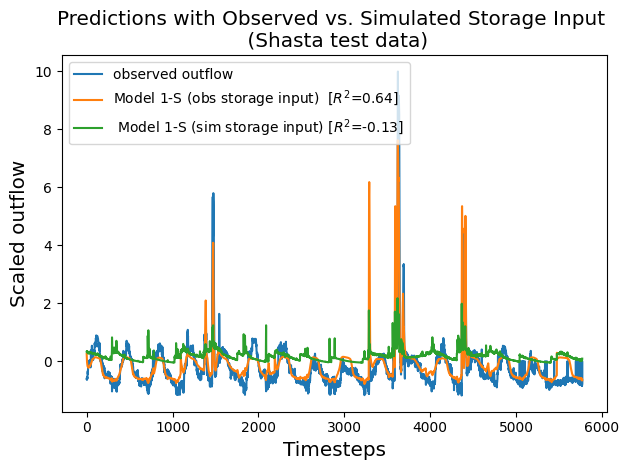

In [32]:
implied_out, implied_storages = predict_sub_implied_storage(model=model, x=test_tuple[0], initial_storage=0, mean=scaler.mean, std=scaler.std, conv_factor=86400 / 43559.9)
y_hat = predict(model=model, x=test_tuple[0])

# flatten, remove pad values
y_hat, y = flatten_rm_pad(y_hat, test_tuple[1])
implied_y_hat, _ = flatten_rm_pad(implied_out, test_tuple[1])
implied_storages, _ = flatten_rm_pad(implied_storages, test_tuple[1])

# plot
fig, ax = plt.subplots()
ax.plot(y, label='observed outflow')
ax.plot(y_hat, label=f'Model 1-S (obs storage input)  [$R^2$={round(r2_score(y, y_hat), 2)}]')
ax.plot(implied_y_hat, label=f' Model 1-S (sim storage input) [$R^2$={round(r2_score(y, implied_y_hat), 2)}]')
ax.set_ylabel("Scaled outflow", size='x-large')
ax.set_xlabel("Timesteps", size='x-large')
ax.set_title("Predictions with Observed vs. Simulated Storage Input \n (Shasta test data)", size='x-large')
ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig("report/drafting/8_15_2025/Figures/model1s_shasta_sim_input.png", dpi=300)
plt.show()

## ResOPS Reservoirs
Repeat experiment for resops reservoirs

In [19]:
def data_processing_resops(res_id, transform_type, left, right='2020-12-31', train_frac=0.6, val_frac=0.2, test_frac=0.2, return_scaler=False, storage=False):
    """
    Run data processing pipeline for one ResOPS reservoir.
    Params:
    res_id -- int, ResOPS reservoir ID
    transform_type -- str, in preprocessing, whether to 'standardize' or 'normalize' the data
    left -- str (YYYY-MM-DD), beginning boundary of time window
    right -- str (YYYY-MM-DD), end boundary of time window
    return_scaler -- bool, whether or not to return src.data.data_processing.time_scaler() object
    storage -- bool, whether or not to include storage data in features
    """

    # Read in data, columns are [inflow, outflow, storage]
    df = resops_fetch_data(res_id=res_id, vars=['inflow', 'outflow', 'storage'])
    # Add day of the year (doy) as another column
    df['doy'] = df.index.to_series().dt.dayofyear
    # Select data window
    df = df[left:right].copy()

    # Run data processing pipeline
    pipeline = processing_pipeline(train_frac=train_frac, val_frac=val_frac, test_frac=test_frac, chunk_size=3*365, pad_value=-1, transform_type=transform_type, fill_na_method='mean')
    # Train/val/test tensors of shape (#chunks, chunksize, [inflow, outflow, storage, doy])
    ts_train, ts_val, ts_test = pipeline.process_data(df) 

    # Separate inputs(X) and targets (y)
    if storage:
        X_train, X_val, X_test = ts_train[:, :, [0, 2, 3]], ts_val[:, :, [0, 2, 3]], ts_test[:, :, [0, 2, 3]]
    else:
        X_train, X_val, X_test = ts_train[:, :, [0, 3]], ts_val[:, :, [0, 3]], ts_test[:, :, [0, 3]]
    # select outflow as target feature
    y_train, y_val, y_test = ts_train[:, :, [1]], ts_val[:, :, [1]], ts_test[:, :, [1]]

    if return_scaler:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test), pipeline.scaler
    else:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)
    
def load_resops_model(res_id, storage):
    """ 
    Load trained LSTM Model 1 for one ResOPS reservoir
    Params:
    res_id -- int, ResOPS reservoir ID
    storage -- bool, whether to load storage-input variant (Model 1S)
    """
    input_size = 3 if storage else 2 # inflow, (optional storage), doy

    hidden_size1 = 30
    hidden_size2 = 15
    output_size = 1 # outflow
    dropout_prob = 0.3
    num_layers = 1

    torch.manual_seed(0)
    model = LSTMModel1_opt(input_size=input_size, hidden_size1=hidden_size1, 
                        hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers, dropout_prob=dropout_prob)
    
    # Load model weights
    model.load_state_dict(torch.load(f'src/models/saved_models/resops_model1/resops_model{"1S" if storage else "1"}_{res_id}.pt', weights_only=True))
    model.eval()
    return model

def eval_sim_storage_1s():
    """
    For every resOPS reservoir in res_list(), evaluate Model 1S using simulated (implied) storage. Return r2_scores as df.
    """
    # For every resops reservoir, evaluate Model 1S on simulated storage
    res_list = filter_res()
    left_years_dict = get_left_years(res_list)

    # Initialize df to store results
    df = pd.DataFrame(index=res_list, columns=['train', 'val', 'test'])

    for res in tqdm(res_list, desc='evaluating sim storage'):
        # Data processing
        (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler = data_processing_resops(res_id=res, transform_type='standardize',
                                                                    left=f'{left_years_dict[res]}-01-01', return_scaler=True, storage=True)
        # Load Model 1S
        model = load_resops_model(res_id=res, storage=True)

        # Evaluate with simulated (implied) storage
        conv_factor = 86400 / 1000000 # m3/s to MCM/day
        y_hat_train, y_hat_val, y_hat_test = (predict_sub_implied_storage(model=model, x=X_train, initial_storage=0, mean=scaler.mean, std=scaler.std, conv_factor=conv_factor)[0],
                                            predict_sub_implied_storage(model=model, x=X_val, initial_storage=0, mean=scaler.mean, std=scaler.std, conv_factor=conv_factor)[0],
                                            predict_sub_implied_storage(model=model, x=X_test, initial_storage=0, mean=scaler.mean, std=scaler.std, conv_factor=conv_factor)[0])
        # Flatten and remove pads
        y_hat_train, y_train = flatten_rm_pad(y_hat=y_hat_train, y=y_train)
        y_hat_val, y_val = flatten_rm_pad(y_hat=y_hat_val, y=y_val)
        y_hat_test, y_test = flatten_rm_pad(y_hat=y_hat_test, y=y_test)

        r2_train, r2_val, r2_test = (r2_score(y_train, y_hat_train), r2_score(y_val, y_hat_val), r2_score(y_test, y_hat_test))
        df.loc[res, :] = (r2_train, r2_val, r2_test)

    return df

In [ ]:
# Commented out since previously run

# r2_scores_1s_sim = eval_sim_storage_1s()
# r2_scores_1s_sim.to_csv('report/results/resops_training/resops_model1s_sim_storage_r2.csv')

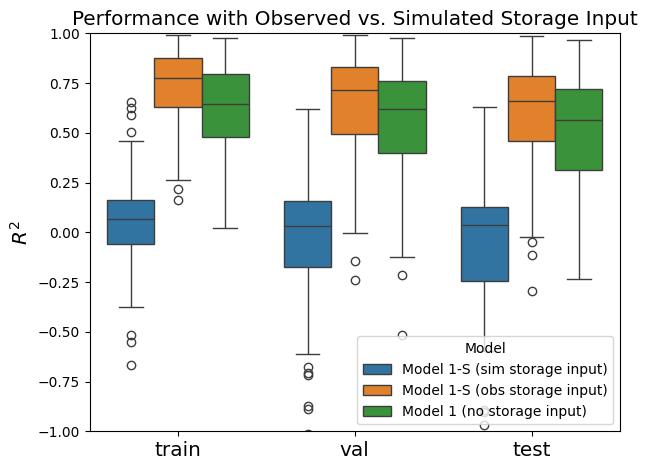

In [30]:
# Read Model 1/1S R2 scores from training individual ResOPS reservoirs
r2_scores_1s_sim = pd.read_csv('report/results/resops_training/resops_model1s_sim_storage_r2.csv', index_col=0)
r2_scores_model1s = pd.read_csv('report/results/resops_training/resops_benchmark_lstm_w_storage_r2.csv', index_col=0)
r2_scores_model1 = pd.read_csv('report/results/resops_training/resops_individual_r2.csv', index_col=0)

# Convert to long format
r2_scores_1s_sim = r2_scores_1s_sim.melt(value_vars=['train', 'val', 'test'])
r2_scores_model1s = r2_scores_model1s.melt(value_vars=['train', 'val', 'test'])
r2_scores_model1 = r2_scores_model1.melt(value_vars=['train', 'val', 'test'])

# Add model type
r2_scores_1s_sim['Model'] = 'Model 1-S (sim storage input)'
r2_scores_model1s['Model'] = 'Model 1-S (obs storage input)'
r2_scores_model1['Model'] = 'Model 1 (no storage input)'
r2_scores_all = pd.concat([r2_scores_1s_sim, r2_scores_model1s, r2_scores_model1], axis=0)

# Plot distribution of performance
fig, ax = plt.subplots()
bp = sns.boxplot(data=r2_scores_all, x='variable', y='value', hue='Model')
ax.set_title('Performance with Observed vs. Simulated Storage Input', size='x-large')
ax.set_ylabel('$R^2$', size='x-large')
ax.set_xlabel('')
plt.setp(ax.get_xticklabels(), size='x-large')
plt.ylim(-1, 1)
plt.tight_layout()
plt.savefig("report/drafting/8_15_2025/Figures/model1s_sim_input_resops.png", dpi=300)
plt.show()